In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

###make two list: one holds names of images of people wearing masks and one of people without masks.

In [4]:
DIR_with_mask = "/content/drive/My Drive/dataset/with_mask"
DIR_without_mask = "/content/drive/My Drive/dataset/without_mask"

imgs_file_name_with_mask = [os.path.join(DIR_with_mask, file)  for file in os.listdir(DIR_with_mask) if not  file.endswith(".DS_Store")]
number_with_max = len(imgs_file_name_with_mask)

imgs_file_name_without_mask = [os.path.join(DIR_without_mask, file)  for file in os.listdir(DIR_without_mask) if not file.endswith(".DS_Store")]
number_without_mask = len(imgs_file_name_without_mask)

###load the images and save them in variable data, and save the corresponding labels.

In [4]:
from PIL import Image
import glob

CHANNELS = 3
IMAGE_SIZE = 224
DATA_SIZE = number_with_max + number_without_mask
data = np.zeros((DATA_SIZE ,IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
labels = []
j = -1 

print("loading with mask data ...")
for filename in imgs_file_name_with_mask:
    j = j + 1
    #load the image
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    # add the loaded image and the corresponding label
    data[j,:,:,:] =image
    labels.append(1)

print("loading without mask data ...")
for filename in imgs_file_name_without_mask: 
    j = j + 1
    #load the image
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # add the loaded image and the corresponding label
    data[j,:,:,:] =image
    labels.append(0)

print("done")

loading with mask data ...


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


loading without mask data ...
done


In [ ]:
# convert labels from [1,1,1,0,0,0,1,1,...] to [[1,0],[1,0],[1,0],[0,1],[0,1]]
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


In [6]:
# splite the data to training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
                                                  test_size=0.20, stratify=labels, random_state=42)

data = []

In [7]:
# applay an augmentation for images
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [8]:
# we want to load vgg16 model without it's final layers, add a pooling and a dense layer and the output layer and finetune it.
vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

x = vgg16.output
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten(name="flatten")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(labels.shape[1], activation="softmax")(x)

model = Model(inputs=vgg16.input, outputs=x)
# we don't want to retrain layers of vgg16
for layer in vgg16.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [9]:
print(testX.shape)
print(trainX.shape)

(767, 224, 224, 3)
(3066, 224, 224, 3)


In [10]:
LEARNING_RATE = 1e-4
EPOCHS = 20
BATCH_SIZE = 64

# out optimizers is adam with initial value = 1e-4 and with decay 0.8 
opt = Adam(lr=LEARNING_RATE, decay=LEARNING_RATE * 0.8)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the model.
training = model.fit(aug.flow(trainX, trainY, batch_size=BATCH_SIZE), 
              steps_per_epoch=len(trainX) // BATCH_SIZE, 
              validation_data=(testX, testY), 
              validation_steps=len(testX) // BATCH_SIZE, 
              epochs=EPOCHS)

Epoch 1/20
47/47 [==============================] - 41s 867ms/step - loss: 0.6845 - accuracy: 0.5896 - val_loss: 0.5073 - val_accuracy: 0.9218
Epoch 2/20
47/47 [==============================] - 35s 748ms/step - loss: 0.5563 - accuracy: 0.7258 - val_loss: 0.4118 - val_accuracy: 0.9531
Epoch 3/20
47/47 [==============================] - 35s 747ms/step - loss: 0.4601 - accuracy: 0.8165 - val_loss: 0.3385 - val_accuracy: 0.9544
Epoch 4/20
47/47 [==============================] - 35s 750ms/step - loss: 0.4014 - accuracy: 0.8698 - val_loss: 0.2918 - val_accuracy: 0.9570
Epoch 5/20
47/47 [==============================] - 35s 736ms/step - loss: 0.3504 - accuracy: 0.8974 - val_loss: 0.2509 - val_accuracy: 0.9622
Epoch 6/20
47/47 [==============================] - 35s 741ms/step - loss: 0.3173 - accuracy: 0.9041 - val_loss: 0.2228 - val_accuracy: 0.9635
Epoch 7/20
47/47 [==============================] - 35s 739ms/step - loss: 0.2781 - accuracy: 0.9207 - val_loss: 0.2001 - val_accuracy: 0.9622

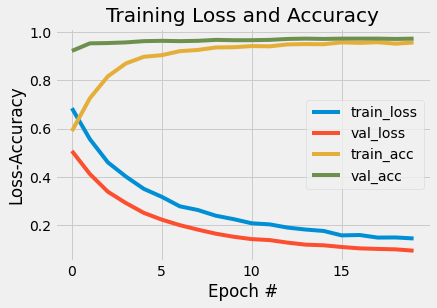

In [11]:
plt.style.use("fivethirtyeight")
plt.figure()
plt.plot(np.arange(0, EPOCHS), training.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), training.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), training.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), training.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss-Accuracy")
plt.legend(loc="right")

In [12]:
pred = model.predict(testX, batch_size=BATCH_SIZE)
predected_classes = np.argmax(pred, axis=1)
actual_classes = testY.argmax(axis=1)
print(classification_report(actual_classes, predected_classes))


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       384
           1       0.98      0.96      0.97       383

    accuracy                           0.97       767
   macro avg       0.97      0.97      0.97       767
weighted avg       0.97      0.97      0.97       767



In [13]:
# serialize the model to disk
model_file_name = "/content/drive/My Drive/Mask_Detector_model.model"
model.save(model_file_name, save_format="h5")